**Homeworks – Statistical learning, 2021/22. semester I.**

*Week 2*

- name: Nagy, Balázs
- neptun: hpq7oi
- e-mail: [balazs_nagy@outlook.com](balazs_nagy@outlook.com)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools

In [2]:
def haty_norm2(X, y):
    q, r = np.linalg.qr(X)
    return (np.dot(q.T, y)**2).sum()

def best_k(X, y, k):
    best_v = 0
    best_c = None
    for c in itertools.combinations(range(X.shape[1]), k):
        v = haty_norm2(X[:, c], y)
        if v > best_v:
            best_v = v
            best_c = c
    return best_c, best_v

def best(X, y, c1=[], v1=0):
    x0 = X[:,-1]
    x0 = x0/(1e-30+np.linalg.norm(x0))
    x0y = np.dot(x0, y) # (x0*y).sum()
    v0 = x0y*x0y
        
    if X.shape[1]==1:
        return [(c1,  v1), (c1+[0], v1+v0)]

    X = X[:, :-1]
    k = X.shape[1]
    a = best(X, y, c1, v1) + [([], -1)]
    X = X - np.outer(x0, np.dot(X.T, x0))
    # y = y - x0y*x0
    b = [(c1, v1)] + best(X, y, c1+[k], v1+v0)
    c = [(ca, va) if va>vb else (cb, vb)  for (ca,va), (cb,vb) in zip(a,b)]
    return c

def best_subset(X, y, *args, **kwargs):
    col_names = X.columns
    y, X = np.asarray(y), np.asarray(X)
    y = y - y.mean(axis=0)
    X = X - X.mean(axis=0)
    q, r = np.linalg.qr(X)
    TSS = (y**2).sum()
    y = np.dot(q.T, y)
    def result(x):
        c, v = x
        return {
            'num_pred': len(c),
            'predictors': [col_names[i] for i in sorted(c)],
            'r2': v/TSS
        }
    return pd.DataFrame([result(x) for x in best(r, y) if x[0]]).set_index('num_pred')

def forward(y, X):
    col_names = list(X.columns)
    y, X = np.asarray(y), np.asarray(X)
    # remove constant effect
    y = y - y.mean(axis=0)
    X = X - X.mean(axis=0)
    
    # total sum of squares
    TSS = (y**2).sum()
    
    # Reduce dimension to p by QR
    q, X = np.linalg.qr(X)
    y = np.dot(q.T, y)
    
    
    tv = 0
    result = []
    predictors = []
    while len(col_names)>0:
        # find best predictor from the inactive predictors
        (c,), v = best_k(y=y, X=X, k=1)
        tv += v
        predictors.append(col_names.pop(c))
        result.append(dict(num_pred=len(predictors), predictors=predictors.copy(), r2=tv/TSS))
        
        # remove the selected predictors from the inactive set
        x, X = X[:,c], X[:,np.arange(X.shape[1])!=c] 
        
        # orthogonalize the inactive predictors with respect to the just selected one.
        x = x/np.linalg.norm(x)
        y = y - np.dot(y,x)*x
        X = X - np.outer(x, np.dot(x.T, X))
    return pd.DataFrame(result).set_index('num_pred')

def backward(y, X):
    col_names = list(X.columns)
    y, X = np.asarray(y), np.asarray(X)
    
    # remove constant effect
    y = y - y.mean(axis=0)
    X = X - X.mean(axis=0)
    
    # total sum of squares
    TSS = (y**2).sum()
    
    # Reduce dimension to p by QR
    q, X = np.linalg.qr(X)
    y = np.dot(q.T, y)
    
    
    tv = 0
    result = []
    while len(col_names)>1:
        # find the best subset of the active set that misses only one predictor.
        c, v = best_k(y=y, X=X, k=len(col_names)-1)
        
        # bookkeeping
        col_names = [col_names[i] for i in c]
        result.append(dict(num_pred=len(c), 
                           predictors=col_names, 
                           r2=v/TSS))
        # remove the selected predictor from the active set.
        X = X[:,c] 
    return pd.DataFrame(result).set_index('num_pred')

# Exercise a)

## Problem

![img/week2a.png](img/week2a.png)

## Solution

In [3]:
np.random.seed(1)
n = 100
x = np.random.rand(n)
epsilon = np.random.rand(n)

# Exercise b)

## Problem

![img/week2b.png](img/week2b.png)

## Solution

In [4]:
# beta coefficients
b0, b1, b2, b3 = (1, 2, 3, 4)
# response vector
y = b0 + b1*x + b2*x**2 + b3*x**3 + epsilon

# Exercise c)

## Problem

![img/week2c.png](img/week2c.png)

## Solution

In [5]:
p = 10
data = pd.concat([pd.DataFrame({'y': y}), pd.DataFrame({f'x{i}': x**i for i in range(1, p+1)})], axis=1)
data

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,2.972504,0.417022,1.739074e-01,7.252319e-02,3.024377e-02,1.261232e-02,5.259613e-03,2.193375e-03,9.146855e-04,3.814440e-04,1.590705e-04
1,6.019321,0.720324,5.188674e-01,3.737529e-01,2.692234e-01,1.939282e-01,1.396912e-01,1.006230e-01,7.248121e-02,5.220999e-02,3.760814e-02
2,1.886171,0.000114,1.308160e-08,1.496205e-12,1.711282e-16,1.957276e-20,2.238631e-24,2.560430e-28,2.928487e-32,3.349452e-36,3.830929e-40
3,2.346689,0.302333,9.140498e-02,2.763470e-02,8.354871e-03,2.525950e-03,7.636769e-04,2.308844e-04,6.980387e-05,2.110398e-05,6.380422e-06
4,2.279302,0.146756,2.153729e-02,3.160724e-03,4.638549e-04,6.807344e-05,9.990179e-06,1.466118e-06,2.151614e-07,3.157620e-08,4.633994e-09
...,...,...,...,...,...,...,...,...,...,...,...
95,2.627838,0.237027,5.618179e-02,1.331660e-02,3.156393e-03,7.481504e-04,1.773318e-04,4.203243e-05,9.962820e-06,2.361457e-06,5.597290e-07
96,8.217967,0.903380,8.160946e-01,7.372431e-01,6.660103e-01,6.016601e-01,5.435274e-01,4.910115e-01,4.435698e-01,4.007118e-01,3.619949e-01
97,4.124256,0.573679,3.291082e-01,1.888026e-01,1.083122e-01,6.213647e-02,3.564642e-02,2.044962e-02,1.173153e-02,6.730137e-03,3.860941e-03
98,1.622544,0.002870,8.238777e-06,2.364799e-08,6.787745e-11,1.948305e-13,5.592272e-16,1.605165e-18,4.607348e-21,1.322460e-23,3.795892e-26


In [6]:
%%time
# find the best subsets based on R2
fit = best_subset(y=data['y'], X=data.drop(columns=['y']), max_k=10)

# fit OLS to the best subset models and store the results
fit['model'] = [sm.OLS.from_formula(f, data=data).fit() 
                for f in fit['predictors'].apply(lambda x: 'y ~ ' + ' + '.join(sorted(x)))]

# extract main measures from the fitted models
measures = pd.DataFrame.from_dict({p:
                        {'coef': row['model'].params,
                         'aic': row['model'].aic,
                         'bic': row['model'].bic,
                         'log-likelihood': row['model'].llf,
                         'rsquared': row['model'].rsquared,
                         'rsquared_adj': row['model'].rsquared_adj,
                         'rss': row['model'].ssr,
                         'tss': row['model'].centered_tss}
                        for p, row in fit.iterrows()}, orient='index')

# concatenate the measures to the original dataframe
fit = pd.concat([fit, measures], axis=1)

# extract number of predictors for easier use
fit.insert(0, 'p', fit.index)

Wall time: 155 ms


In [7]:
fit

,p,predictors,r2,model,coef,aic,bic,log-likelihood,rsquared,rsquared_adj,rss,tss
1,1,[x2],0.984742,<statsmodels.regression.linear_model.Regressio...,Intercept 1.619162 x2 8.587109 dt...,58.501959,63.712299,-27.250979,0.984742,0.984587,10.097751,661.813139
2,2,"[x2, x10]",0.985062,<statsmodels.regression.linear_model.Regressio...,Intercept 1.650190 x10 0.413934 x2...,58.385201,66.200711,-26.192600,0.985062,0.984754,9.886252,661.813139
3,3,"[x1, x2, x9]",0.985169,<statsmodels.regression.linear_model.Regressio...,Intercept 1.578237 x1 0.523334 x2...,59.667508,70.088189,-25.833754,0.985169,0.984705,9.815553,661.813139
4,4,"[x2, x8, x9, x10]",0.985204,<statsmodels.regression.linear_model.Regressio...,Intercept 1.615763 x10 -42.108541 ...,61.430884,74.456735,-25.715442,0.985204,0.984581,9.792355,661.813139
5,5,"[x1, x3, x8, x9, x10]",0.985257,<statsmodels.regression.linear_model.Regressio...,Intercept 1.536214 x1 1.82798...,63.068996,78.700018,-25.534498,0.985257,0.984473,9.756982,661.813139
6,6,"[x2, x3, x4, x6, x7, x8]",0.985313,<statsmodels.regression.linear_model.Regressio...,Intercept 1.557607 x2 24.80031...,64.692850,82.929041,-25.346425,0.985313,0.984365,9.720350,661.813139
7,7,"[x1, x2, x3, x4, x5, x6, x7]",0.985384,<statsmodels.regression.linear_model.Regressio...,Intercept 1.656964 x1 -5.731...,66.205537,87.046898,-25.102768,0.985384,0.984272,9.673097,661.813139
8,8,"[x1, x2, x3, x4, x5, x6, x7, x8]",0.985409,<statsmodels.regression.linear_model.Regressio...,Intercept 1.689316 x1 -8.900...,68.036818,91.483350,-25.018409,0.985409,0.984126,9.656790,661.813139
9,9,"[x1, x2, x3, x4, x5, x6, x7, x8, x9]",0.985431,<statsmodels.regression.linear_model.Regressio...,Intercept 1.716993 x1 -12.3...,69.884801,95.936503,-24.942401,0.985431,0.983974,9.642121,661.813139
10,10,"[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]",0.985771,<statsmodels.regression.linear_model.Regressio...,Intercept 1.816911 x1 -29...,69.524698,98.181570,-23.762349,0.985771,0.984172,9.417222,661.813139


Below we can see how the measures are calculated behind the scenes:

In [8]:
# AIC
AIC = -2*fit['log-likelihood']+2*(fit['p']+1) # +1 due to intersect
# BIC
BIC = -2*fit['log-likelihood']+(fit['p']+1)*np.log(n) # +1 due to intersect
# TSS
TSS = sum((y - np.mean(y))**2)
# R2
rsquared = 1 - fit['rss']/fit['tss']
# R2 adjusted
rsquared_adj = 1 - (fit['rss']/(n-fit['p']-1))/(fit['tss']/(n-1)) # -1 due to intersect

print(f'''Recalculating the measures "by hand":
'AIC': {np.sqrt(sum(AIC - fit['aic'])**2)}
'BIC': {np.sqrt(sum(BIC - fit['bic'])**2)}
'TSS': {np.sqrt(sum(TSS - fit['tss'])**2)}
'R2': {np.sqrt(sum(rsquared - fit['rsquared'])**2)}
'R2_adj': {np.sqrt(sum(rsquared_adj - fit['rsquared_adj'])**2)}''')

Recalculating the measures "by hand":
'AIC': 0.0
'BIC': 0.0
'TSS': 2.2737367544323206e-12
'R2': 0.0
'R2_adj': 4.440892098500626e-16


We can plot the results to quickly find the best models:

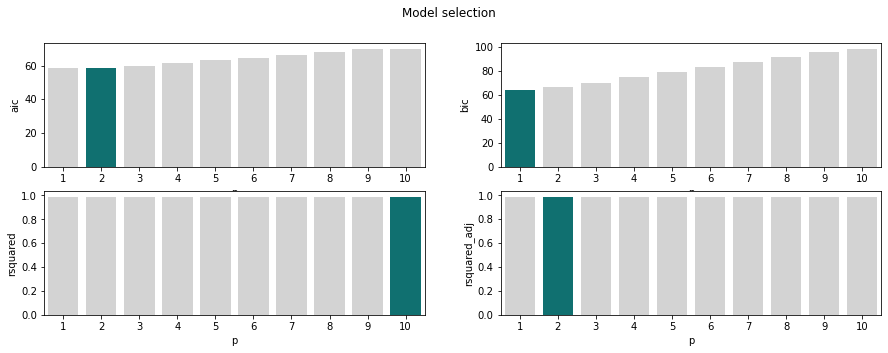

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle('Model selection')

cmaps = {'aic': ['lightgrey' if (x != min(measures['aic'])) else 'teal' for x in fit['aic']],
         'bic': ['lightgrey' if (x != min(measures['bic'])) else 'teal' for x in fit['bic']],
         'rsquared': ['lightgrey' if (x != max(fit['rsquared'])) else 'teal' for x in fit['rsquared']],
         'rsquared_adj': ['lightgrey' if (x != max(fit['rsquared_adj'])) else 'teal' for x in fit['rsquared_adj']]}

for i, measure in enumerate(cmaps.keys()):
    sns.barplot(ax=axes[i // 2, i % 2], y=measure, x='p', data=fit, palette=cmaps.get(measure))
    
plt.show()

Based on the BIC the best subset selection model is the model with 1 predictor:

$$
\hat{y} = \hat{\beta_0} + \hat{\beta_1}x^{2}
$$

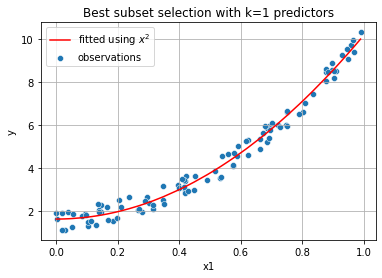

p                                                                 1
predictors                                                     [x2]
r2                                                         0.984742
model             <statsmodels.regression.linear_model.Regressio...
coef              Intercept    1.619162
x2           8.587109
dt...
aic                                                          58.502
bic                                                         63.7123
log-likelihood                                              -27.251
rsquared                                                   0.984742
rsquared_adj                                               0.984587
rss                                                         10.0978
tss                                                         661.813
Name: 1, dtype: object

The model coefficients: 

Intercept    1.619162
x2           8.587109
dtype: float64


In [10]:
# number of predictors
k = 1

# plot fitted vs observations
plt.title(f'Best subset selection with k={k} predictors')
sns.scatterplot(x='x1',y='y', data=data, label='observations')
sns.lineplot(x=data['x1'], y=fit.loc[k].model.fittedvalues, color='red', label='fitted using $x^2$')
plt.legend()
plt.grid()
plt.show()

# print model details
print(fit.loc[k])
print('\nThe model coefficients: \n')
print(fit.loc[k].model.params)

Based on the AIC (which is equivalent to Mallow's $C_p$ in case of OLS linear regression models) and the *adjusted-$R^2$* the best model is the model with 2 predictors:

$$
\hat{y} = \hat{\beta_0} + \hat{\beta_1}x^{2} + \hat{\beta_{2}}x^{10}
$$

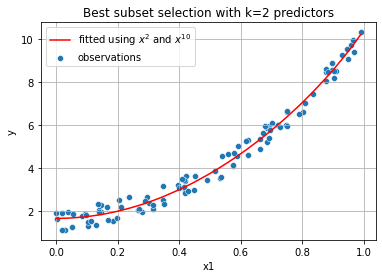

p                                                                 2
predictors                                                [x2, x10]
r2                                                         0.985062
model             <statsmodels.regression.linear_model.Regressio...
coef              Intercept    1.650190
x10          0.413934
x2...
aic                                                         58.3852
bic                                                         66.2007
log-likelihood                                             -26.1926
rsquared                                                   0.985062
rsquared_adj                                               0.984754
rss                                                         9.88625
tss                                                         661.813
Name: 2, dtype: object

The model coefficients: 

Intercept    1.650190
x10          0.413934
x2           8.381422
dtype: float64


In [11]:
# number of predictors
k = 2

# plot fitted vs observations
plt.title(f'Best subset selection with k={k} predictors')
sns.scatterplot(x='x1',y='y', data=data, label='observations')
sns.lineplot(x=data['x1'], y=fit.loc[k].model.fittedvalues, color='red', label='fitted using $x^2$ and $x^{10}$')
plt.legend()
plt.grid()
plt.show()

# print model details
print(fit.loc[k])
print('\nThe model coefficients: \n')
print(fit.loc[k].model.params)

Of course the *unadjusted-$R^2$* suggests the overfitted full-model:

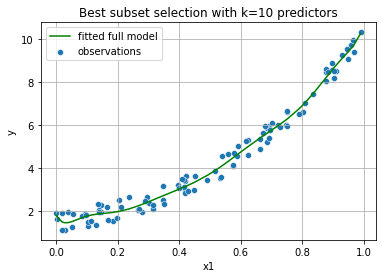

p                                                                10
predictors                [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]
r2                                                         0.985771
model             <statsmodels.regression.linear_model.Regressio...
coef              Intercept         1.816911
x1              -29...
aic                                                         69.5247
bic                                                         98.1816
log-likelihood                                             -23.7623
rsquared                                                   0.985771
rsquared_adj                                               0.984172
rss                                                         9.41722
tss                                                         661.813
Name: 10, dtype: object

The model coefficients: 

Intercept         1.816911
x1              -29.113817
x10           41541.907864
x2              766.248173
x3            -8347.53618

In [12]:
# number of predictors
k = 10

# plot fitted vs observations
plt.title(f'Best subset selection with k={k} predictors')
sns.scatterplot(x='x1',y='y', data=data, label='observations')
sns.lineplot(x=data['x1'], y=fit.loc[k].model.fittedvalues, color='green', label='fitted full model')
plt.legend()
plt.grid()
plt.show()

# print model details
print(fit.loc[k])
print('\nThe model coefficients: \n')
print(fit.loc[k].model.params)

# Exercise d)

## Problem

![img/week2d.png](img/week2d.png)

## Solution

### Forward stepwise

In [13]:
fwd_fit = forward(y=data['y'], X=data.drop(columns=['y']))
# fit OLS to the forward stepwise models and store the results
fwd_fit['model'] = [sm.OLS.from_formula(f, data=data).fit() 
                for f in fwd_fit['predictors'].apply(lambda x: 'y ~ ' + ' + '.join(sorted(x)))]

# extract main measures from the fitted models
measures = pd.DataFrame.from_dict({p:
                        {'coef': row['model'].params,
                         'aic': row['model'].aic,
                         'bic': row['model'].bic,
                         'log-likelihood': row['model'].llf,
                         'rsquared': row['model'].rsquared,
                         'rsquared_adj': row['model'].rsquared_adj,
                         'rss': row['model'].ssr,
                         'tss': row['model'].centered_tss}
                        for p, row in fwd_fit.iterrows()}, orient='index')

# concatenate the measures to the original dataframe
fwd_fit = pd.concat([fwd_fit, measures], axis=1)

# extract number of predictors for easier use
fwd_fit.insert(0, 'p', fwd_fit.index)

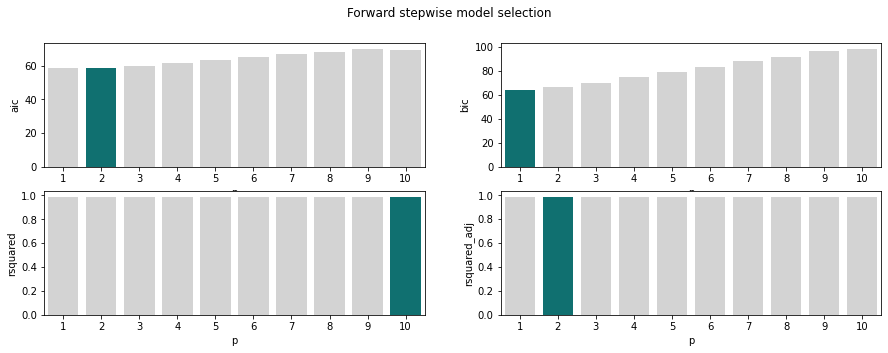

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle('Forward stepwise model selection')

cmaps = {'aic': ['lightgrey' if (x != min(fwd_fit['aic'])) else 'teal' for x in fwd_fit['aic']],
         'bic': ['lightgrey' if (x != min(fwd_fit['bic'])) else 'teal' for x in fwd_fit['bic']],
         'rsquared': ['lightgrey' if (x != max(fwd_fit['rsquared'])) else 'teal' for x in fwd_fit['rsquared']],
         'rsquared_adj': ['lightgrey' if (x != max(fwd_fit['rsquared_adj'])) else 'teal' for x in fwd_fit['rsquared_adj']]}

for i, measure in enumerate(cmaps.keys()):
    sns.barplot(ax=axes[i // 2, i % 2], y=measure, x='p', data=fwd_fit, palette=cmaps.get(measure))
    
plt.show()

### Backward stepwise

In [15]:
bwd_fit = backward(y=data['y'], X=data.drop(columns=['y']))
# fit OLS to the forward stepwise models and store the results
bwd_fit['model'] = [sm.OLS.from_formula(f, data=data).fit() 
                for f in bwd_fit['predictors'].apply(lambda x: 'y ~ ' + ' + '.join(sorted(x)))]

# extract main measures from the fitted models
measures = pd.DataFrame.from_dict({p:
                        {'coef': row['model'].params,
                         'aic': row['model'].aic,
                         'bic': row['model'].bic,
                         'log-likelihood': row['model'].llf,
                         'rsquared': row['model'].rsquared,
                         'rsquared_adj': row['model'].rsquared_adj,
                         'rss': row['model'].ssr,
                         'tss': row['model'].centered_tss}
                        for p, row in bwd_fit.iterrows()}, orient='index')

# concatenate the measures to the original dataframe
bwd_fit = pd.concat([bwd_fit, measures], axis=1)

# extract number of predictors for easier use
bwd_fit.insert(0, 'p', bwd_fit.index)

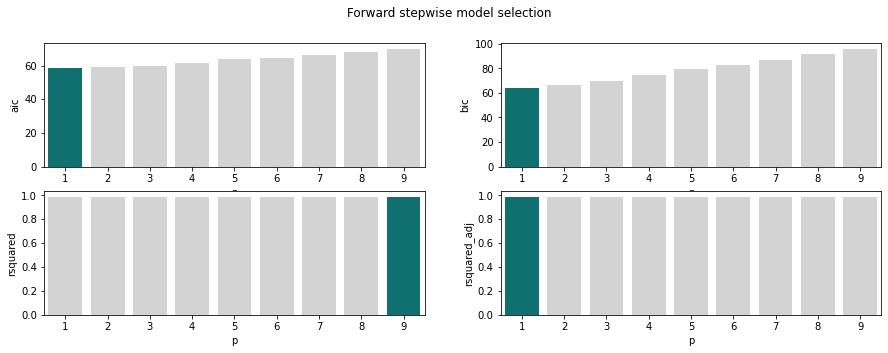

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle('Forward stepwise model selection')

cmaps = {'aic': ['lightgrey' if (x != max(bwd_fit['aic'])) else 'teal' for x in bwd_fit['aic']],
         'bic': ['lightgrey' if (x != max(bwd_fit['bic'])) else 'teal' for x in bwd_fit['bic']],
         'rsquared': ['lightgrey' if (x != min(bwd_fit['rsquared'])) else 'teal' for x in bwd_fit['rsquared']],
         'rsquared_adj': ['lightgrey' if (x != min(bwd_fit['rsquared_adj'])) else 'teal' for x in bwd_fit['rsquared_adj']]}

for i, measure in enumerate(cmaps.keys()):
    sns.barplot(ax=axes[i // 2, i % 2], y=measure, x='p', data=bwd_fit, palette=cmaps.get(measure))
    
plt.show()

### Comparison

In [17]:
comparison = pd.DataFrame({'best subset': fit.loc[2],
                          'forward': fwd_fit.loc[2],
                          'backward': bwd_fit.loc[1]})
comparison

,best subset,forward,backward
p,2,2,1
predictors,"[x2, x10]","[x2, x10]",[x2]
r2,0.985062,0.985062,0.984742
model,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
coef,Intercept 1.650190 x10 0.413934 x2...,Intercept 1.650190 x10 0.413934 x2...,Intercept 1.619162 x2 8.587109 dt...
aic,58.3852,58.3852,58.502
bic,66.2007,66.2007,63.7123
log-likelihood,-26.1926,-26.1926,-27.251
rsquared,0.985062,0.985062,0.984742
rsquared_adj,0.984754,0.984754,0.984587


In [18]:
for method in comparison.columns:
    print(method)
    print('='*40)
    print(comparison[method]['coef'])
    print('\n')

best subset
Intercept    1.650190
x10          0.413934
x2           8.381422
dtype: float64


forward
Intercept    1.650190
x10          0.413934
x2           8.381422
dtype: float64


backward
Intercept    1.619162
x2           8.587109
dtype: float64




# Exercise e)

## Problem

![img/week2e.png](img/week2e.png)

## Solution

In [19]:
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, lars_path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [20]:
def check_sklearn():
    from importlib_metadata import metadata
    version = metadata('scikit-learn').get('Version')
    major, minor = list(map(int, version.split('.')[:2]))
    if major==0:
        print(f"sklearn version is {version}, please upgrade by uncommenting and running the next cell!")
    else:
        print(f"Your sklearn version=`{version}` seems to be up to date") 
check_sklearn()

Your sklearn version=`1.0.1` seems to be up to date


In [21]:
def coeff_and_mse(model, 
                  X, y, 
                  X_test=None, y_test=None, 
                  **params):
    estimator = model[-1] if isinstance(model, sklearn.pipeline.Pipeline) else model
    estimator.set_params(**params)
    mse = mean_squared_error(model.fit(X, y).predict(X), y)
    t_mse = mean_squared_error(model.predict(X_test), y_test)
    result = dict(zip(model[:-1].get_feature_names_out(), estimator.coef_))
    result['train_mse'] = mse
    result['test_mse'] = t_mse
    result.update(params)
    return result

In [22]:
def print_result(estimator, X_test=None, y_test=None):
    intercept, coef = estimator[-1].intercept_, estimator[-1].coef_
    df = pd.DataFrame(coef[None], columns=estimator[0].feature_names_in_)
    df['intercept'] = intercept
    print('-'*20)
    print(f'alpha={estimator[-1].alpha}')
    print('-'*20)
    print(df.to_string(line_width=80, index=False))
    if not(X_test is None or y_test is None):
        pred = estimator.predict(X=X_test)
        print('-'*20)
        print(f'MSE {mean_squared_error(y_test, pred):.2f}')
        print('-'*20)

In [23]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(data.drop(columns=['y']), data['y'], test_size=0.5, random_state=1)

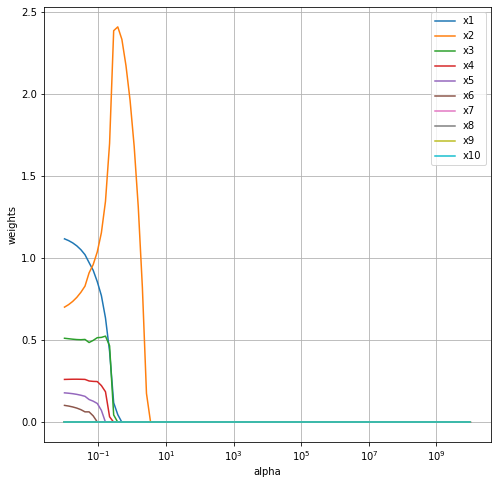

In [24]:
alphas = 10**np.linspace(10, -2, 100)

lasso = make_pipeline(StandardScaler(), 
                      Lasso(max_iter = 10000))

lasso_coef = pd.DataFrame([coeff_and_mse(lasso, X_train, y_train,
                                         X_test, y_test,
                                         alpha=a) for a in alphas]).set_index('alpha')

lasso_coef[data.drop(columns=['y']).columns].plot(figsize=(8, 8))

plt.legend(loc='upper right')
plt.grid()
plt.xscale('log')
plt.axis('tight')
plt.ylabel('weights')
plt.show()

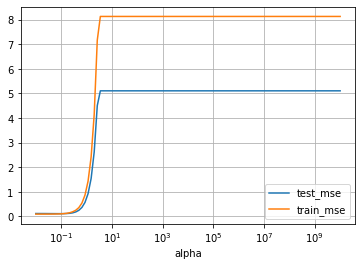

In [25]:
lasso_coef[['test_mse', 'train_mse']].plot()
plt.grid()
plt.xscale('log')
plt.axis('tight')
plt.show()

In [26]:
lassocv = make_pipeline(StandardScaler(),
                        LassoCV(alphas = None, cv=10, max_iter = 100000))

lassocv.fit(X_train, y_train)

lasso['lasso'].set_params(alpha=lassocv['lassocv'].alpha_)
lasso.fit(X_train, y_train)
print_result(lasso, X_test, y_test)

--------------------
alpha=0.030364062078064327
--------------------
       x1        x2        x3        x4        x5        x6   x7   x8   x9  \
 1.052301  0.791337  0.503059  0.261898  0.164737  0.076909  0.0  0.0  0.0   

 x10  intercept  
 0.0   4.363112  
--------------------
MSE 0.12
--------------------


Index(['x1', 'x5', 'x2', 'x7', 'x9', 'x10', 'x4', 'x3'], dtype='object')


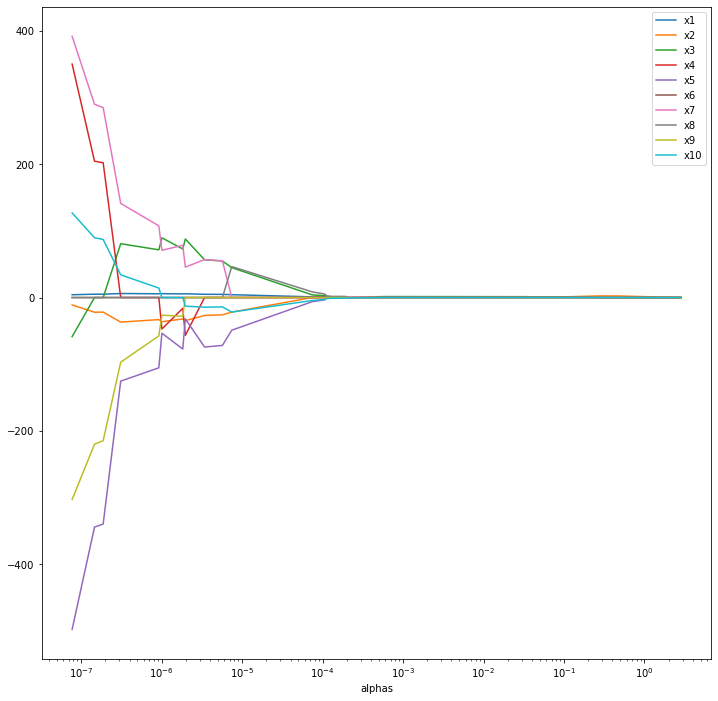

In [27]:
alphas_, active_, coeff_ = lars_path(StandardScaler().fit_transform(X_train), y_train, method='lasso')
result = pd.DataFrame(coeff_.T, columns=X_train.columns)
result['alphas'] = alphas_
result = result.set_index('alphas')

print(X_train.columns[active_])
result.plot(figsize=(12,12))
plt.legend(loc='upper right')
plt.xscale('log')
plt.show()

In [28]:
result.round(2)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
alphas,,,,,,,,,,
2.831763e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4.575279e-01,0.00,2.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2.787494e-01,0.09,2.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1.980579e-01,0.41,1.95,0.00,0.29,0.00,0.00,0.00,0.00,0.00,0.00
9.377490e-02,0.89,0.94,0.50,0.44,0.00,0.00,0.00,0.00,0.00,0.00
9.188763e-02,0.92,0.76,0.92,0.00,0.17,0.00,0.00,0.00,0.00,0.00
3.802551e-02,1.14,0.37,1.07,0.00,0.25,0.00,0.00,0.00,0.00,0.00
3.560833e-02,1.17,0.23,1.30,0.00,0.00,0.15,0.00,0.00,0.00,0.00
5.800708e-04,1.30,0.02,1.37,0.00,0.00,0.20,0.00,0.00,0.00,0.00
